In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

Defining vector space dimension and fixed input size

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 8

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 300

class_names = ['happy', 'sadness', 'fear', 'anger', 'disgust', 'guilt', 'shame', 'surprise']

Importing our training and testing datasets

In [ ]:
data_train = pd.read_csv('data_train1.csv', encoding='utf-8')
data_test = pd.read_csv('data_test1.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
print(data.Emotion.value_counts())
data.head(6)

happy       14445
sadness      2792
anger        2576
surprise     2036
fear         1678
disgust      1515
shame        1200
guilt        1052
Name: Emotion, dtype: int64


,Emotion,Text
0,happy,"Ok , thank you.Goodbye ."
1,guilt,I had planned a trip to the South during Easte...
2,happy,OK . No problem .
3,happy,"Well , it's not how much , but what I'm going..."
4,happy,Everything is now . I'm kind of sick of it .
5,guilt,When my mother scolded me and I argued with her.


In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

*Making things easier for keras tokenizer 🙃

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(texts_train[92])

When my first child was born .


**Tokenization + fitting using keras**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 16034


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[  0,   0,   0, ...,  39,   5, 460],
       [  0,   0,   0, ...,  67,  85,  54],
       [  0,   0,   0, ..., 128,  73, 293],
       ...,
       [  0,   0,   0, ..., 187,   4,  15],
       [  0,   0,   0, ...,   4,  29, 771],
       [  0,   0,   0, ...,   3, 479,  88]], dtype=int32)

**Categorize** labels: 

In [ ]:
encoding = {
    'happy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'disgust': 4,
    'guilt': 5,
    'shame': 6,
    'surprise': 7
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
from tensorflow.keras import utils as np_utils

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english vectors: https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(16035, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 14904
New words found: 1130


In [ ]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4810500   
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 256)          230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 5,109,004
Trainable params: 298,504
Non-trainable params: 4,810,500
_________________________________________________________________


## 3. Train the Model

In [ ]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
91/91 [==============================] - 148s 1s/step - loss: 1.4438 - accuracy: 0.5240 - val_loss: 0.8609 - val_accuracy: 0.7235
Epoch 2/6
91/91 [==============================] - 133s 1s/step - loss: 0.7617 - accuracy: 0.7476 - val_loss: 0.6794 - val_accuracy: 0.7782
Epoch 3/6
91/91 [==============================] - 133s 1s/step - loss: 0.5910 - accuracy: 0.7983 - val_loss: 0.6252 - val_accuracy: 0.7962
Epoch 4/6
91/91 [==============================] - 133s 1s/step - loss: 0.4764 - accuracy: 0.8484 - val_loss: 0.6227 - val_accuracy: 0.7957
Epoch 5/6
91/91 [==============================] - 133s 1s/step - loss: 0.3830 - accuracy: 0.8787 - val_loss: 0.6161 - val_accuracy: 0.8024
Epoch 6/6
91/91 [==============================] - 133s 1s/step - loss: 0.2886 - accuracy: 0.9174 - val_loss: 0.6211 - val_accuracy: 0.8069


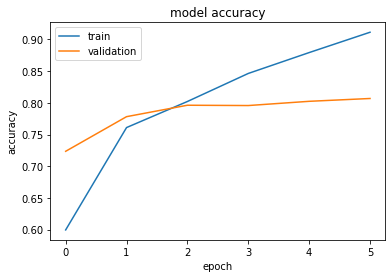

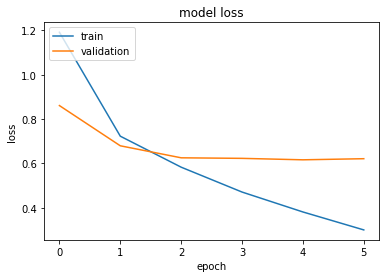

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 80.69%

F1 Score: 80.69


#### Plotting confusion Matrix:

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 80.44


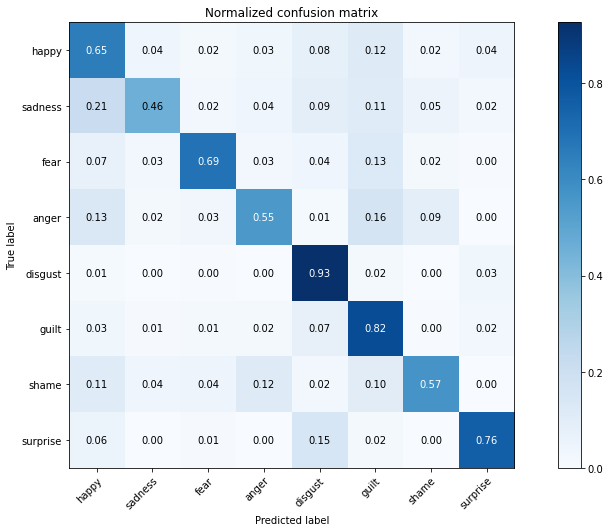

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Let's try other inputs:

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[180], predictions[180]))

Message: Diehard fans might be miffed at some of what 's left out , but it 's tough to argue against any of the songs included .
Predicted: anger


In [ ]:
aarogyatest = pd.read_csv('tracetogethertest.csv', encoding='utf-8')

In [ ]:
aarogyatest

,Text
0,"#TraceTogether, the SG App to control #Covid_1..."
1,Is it just me or is the whole tracetogether ap...
2,SINGAPORE . DETAILED TRACING: \nLearning from ...
3,Singapore is open-sourcing their TraceTogether...
4,Just learned about Singaporean govt.s TraceTog...
...,...
10992,Why rush through legislation for TraceTogether...
10993,The TraceTogether Token should have 2nd-order ...
10994,Govt introduces Bill to restrict Police use of...
10995,Bill introduced to spell out use of TraceToget...


In [ ]:
tweets = aarogyatest['Text']

In [ ]:
seq = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(seq, maxlen=max_seq_len)

pred = model.predict(padded)
pred = np.argmax(pred, axis=1)

In [ ]:
len(pred)

10997

In [ ]:
pred[1:10997]

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
d = pd.DataFrame(pred)

In [ ]:
d

,0
0,0
1,0
2,0
3,0
4,0
...,...
10992,3
10993,0
10994,3
10995,3


In [ ]:
d.to_csv('tracetogetheremotions.csv')

In [ ]:
import time

#message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred1 = model.predict(padded)

print('Message: ' + str(tweets))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred1)], (time.time() - start_time)))

Message: 0        Aarogya Setu - was brought by Narendra Modiji ...
1        Aarogya Setu - was brought by Narendra Modiji ...
2        Aarogya Setu - was brought by Narendra Modiji ...
3        Why is #CowinApp not on iOS? #AarogyaSetu is t...
4        Aarogya Setu - was brought by Narendra Modiji ...
                               ...                        
88999    @ani_digital @ANI Aarogya setu ka kya hua?????...
89000    Hey,Aarogya setu team\nI have an idea for a fe...
89001    @BLRAirport Appreciate your prompt reply sir ....
89002    Aarogya Setu is critical to help us fight agai...
89003    @rajdeepre (2/3)All passengers must download t...
Name: Text, Length: 89004, dtype: object


IndexError: ignored

# Done
Save the model for later use 🙃 

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/cnn_w2v.h5')

In [ ]:
from keras.models import load_model
predictor = load_model('models/cnn_w2v.h5')